In [1]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt

@tf.keras.saving.register_keras_serializable()
class UNetUpscaling(tf.keras.Model):
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)

        self.unit1 = tf.keras.Sequential([
            layers.Conv2D(32, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2D(32, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2DTranspose(32, 2, strides=2, padding='same')
        ])

        self.unit2 = tf.keras.Sequential([
            layers.Conv2D(16, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2D(16, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2DTranspose(16, 2, strides=2, padding='same')
        ])

        self.unit3 = tf.keras.Sequential([
            layers.Conv2D(3, 3, strides=2, padding='same'),
            layers.ReLU()
        ])

    def call(self, inputs):
        x1 = self.unit1(inputs)
        x2 = self.unit2(x1)
        x3 = self.unit3(x2)
        return x3

2024-05-01 20:23:54.481945: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 20:23:54.518875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 20:23:55.080225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_path = './data/minibatch'
HR_path = os.path.join(data_path, 'HR')
LR_path = os.path.join(data_path, 'LR')

INPUT_SHAPE = (None, 50, 50, 3)
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.001
TRAIN_TEST_SPLIT = 0.8
SEED = 42

def hr_to_lr(hr_name):
    """
    000001_patch_0000.png to 000001x2_patch_0000.png
    """
    hr_name = hr_name.split('_')
    hr_name[0] += 'x2'
    return '_'.join(hr_name)

def load_and_preprocess_image(x_path, y_path):
    def load_image(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
    return load_image(x_path), load_image(y_path)

hr_files = os.listdir(HR_path)
lr_files = [hr_to_lr(_) for _ in hr_files]

hr_files = [os.path.join(HR_path, _) for _ in hr_files]
lr_files = [os.path.join(LR_path, _) for _ in lr_files]

split_idx = int(len(hr_files) * TRAIN_TEST_SPLIT)
train_lr_files, train_hr_files = lr_files[:split_idx], hr_files[:split_idx]
test_lr_files, test_hr_files = lr_files[split_idx:], hr_files[split_idx:]

train_ds= tf.data.Dataset.from_tensor_slices((train_lr_files, train_hr_files))
test_ds = tf.data.Dataset.from_tensor_slices((test_lr_files, test_hr_files))

train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

tf.random.set_seed(SEED)
train_ds = train_ds.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

2024-05-01 20:23:56.035015: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 20:23:56.059839: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 20:23:56.059997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

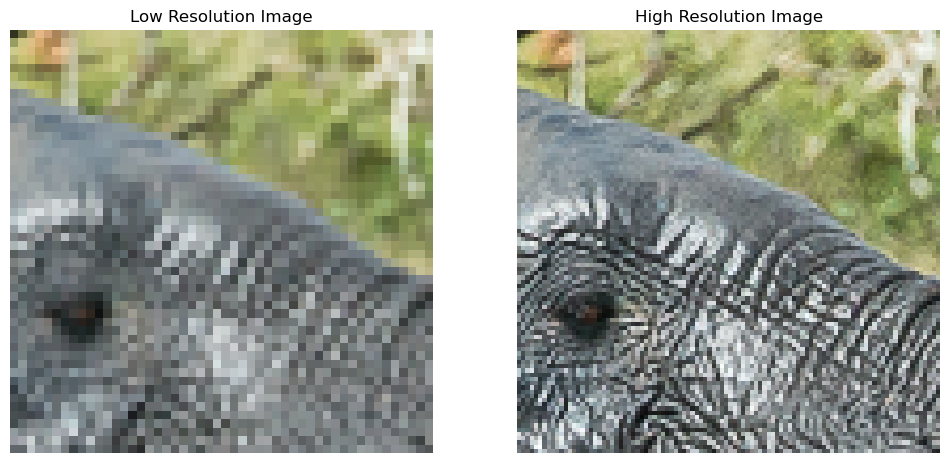

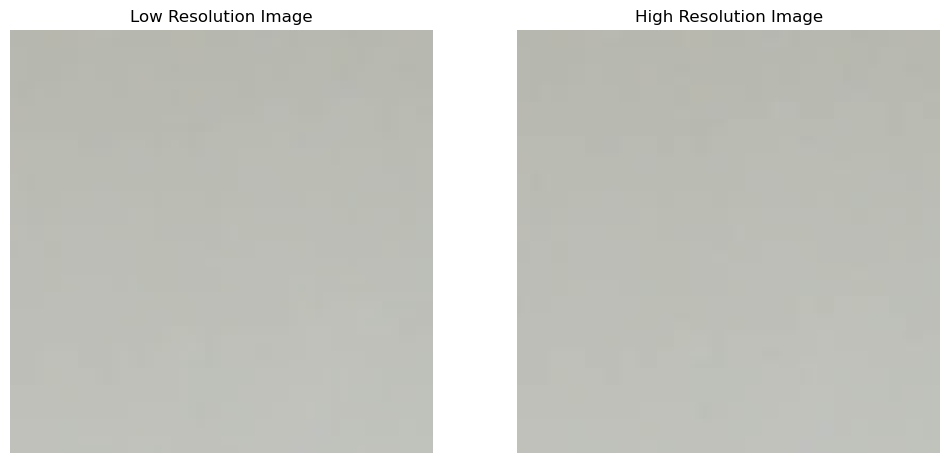

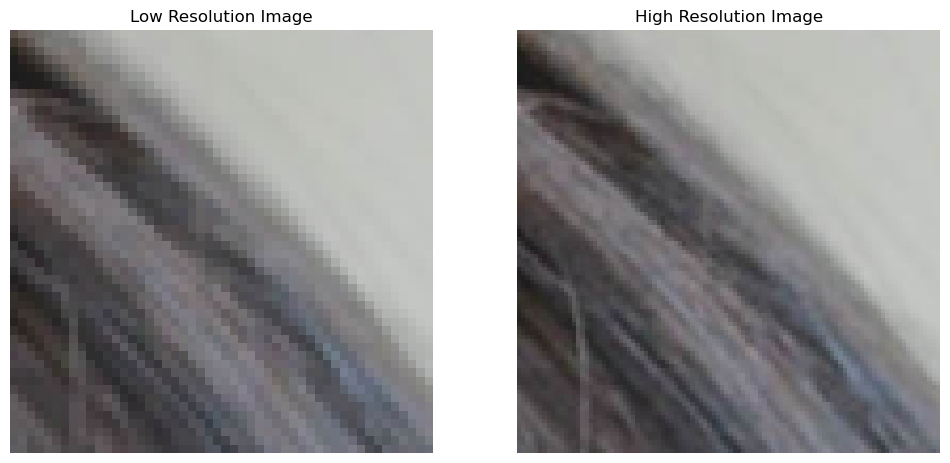

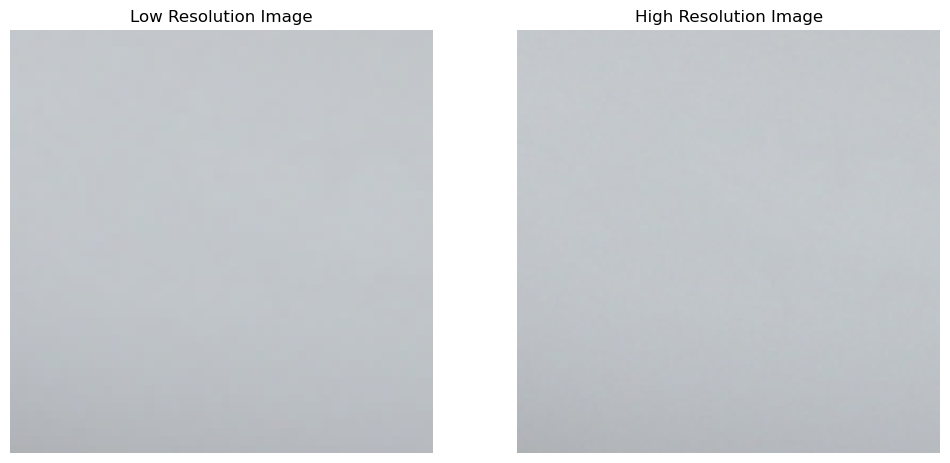

2024-05-01 20:23:57.445119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
for lr_images, hr_images in train_ds.take(4):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Low Resolution Image')
    plt.imshow(lr_images[0])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('High Resolution Image')
    plt.imshow(hr_images[0])
    plt.axis('off')
    
    plt.show()

In [4]:
model = UNetUpscaling()
model.compile(optimizer='adam', loss='mean_squared_error')
model.build(input_shape=INPUT_SHAPE)
model.fit(train_ds, epochs=NUM_EPOCHS, validation_data=test_ds)
print(model.summary())

/home/smellon/.local/lib/python3.12/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'u_net_upscaling', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "u_net_upscaling"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5


I0000 00:00:1714609438.760354   42379 service.cc:145] XLA service 0x7c8a380165b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714609438.760452   42379 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-05-01 20:23:58.801485: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-01 20:23:58.927797: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  10/1336 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - loss: 0.2585

I0000 00:00:1714609443.265328   42379 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1336/1336 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - loss: 0.0165 - val_loss: 0.0011
Epoch 2/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - loss: 0.0012 - val_loss: 9.9621e-04
Epoch 3/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - loss: 0.0012 - val_loss: 9.7152e-04
Epoch 4/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/5
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - loss: 0.0011 - val_loss: 9.3431e-04


In [5]:
a = iter(test_ds)

x_samples, y_samples = next(a)
y_pred = model.predict(x_samples)
y_pred = tf.clip_by_value(y_pred, 0, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


/tmp/ipykernel_42285/1578373123.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


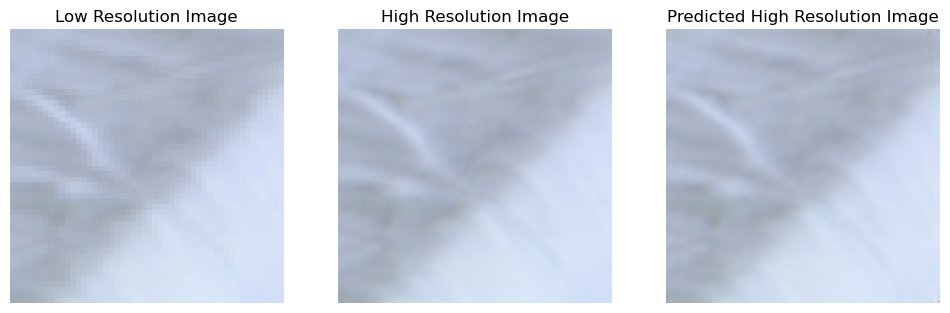

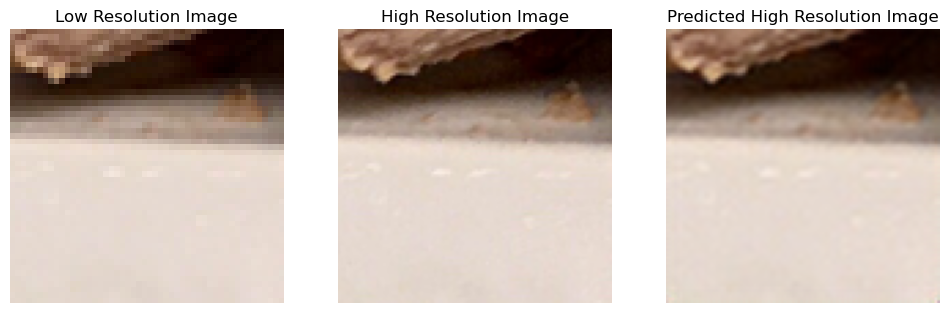

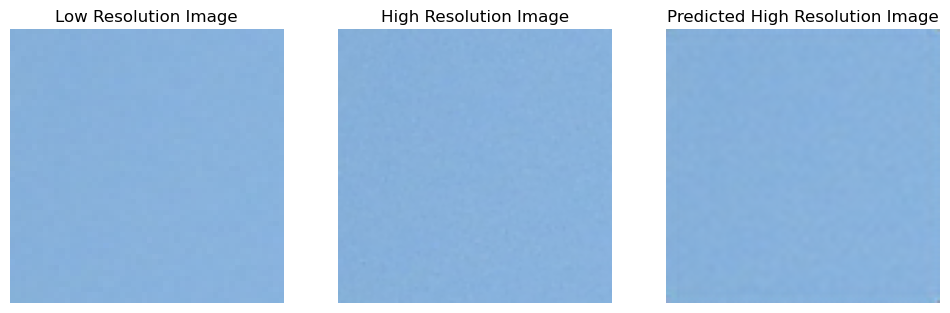

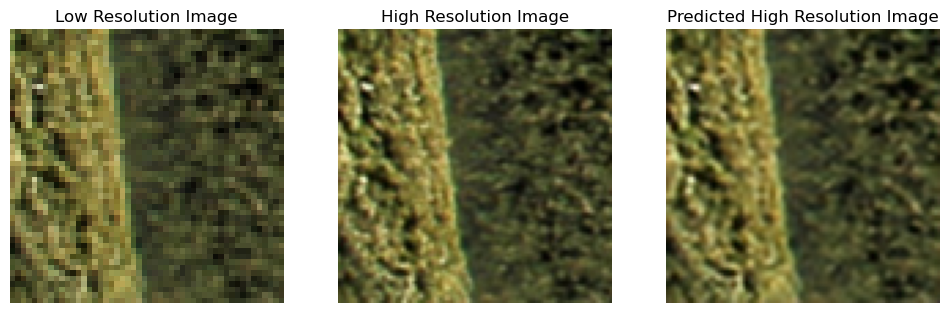

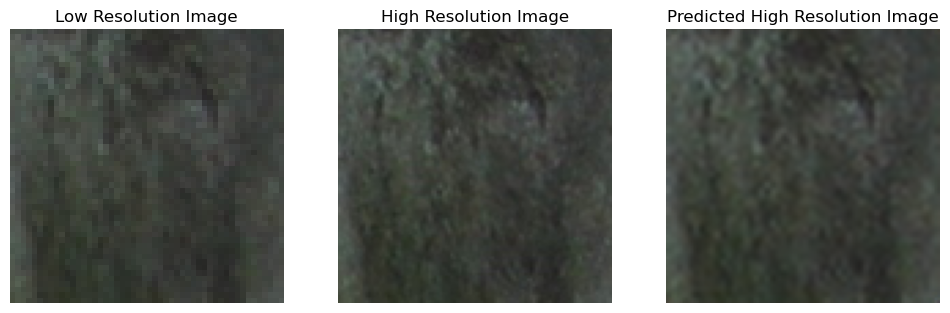

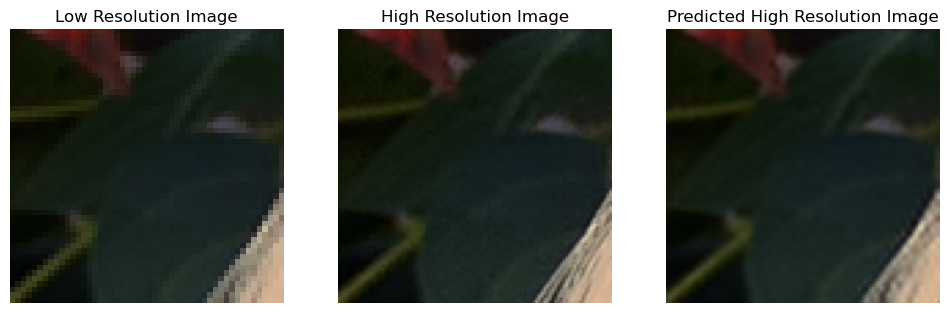

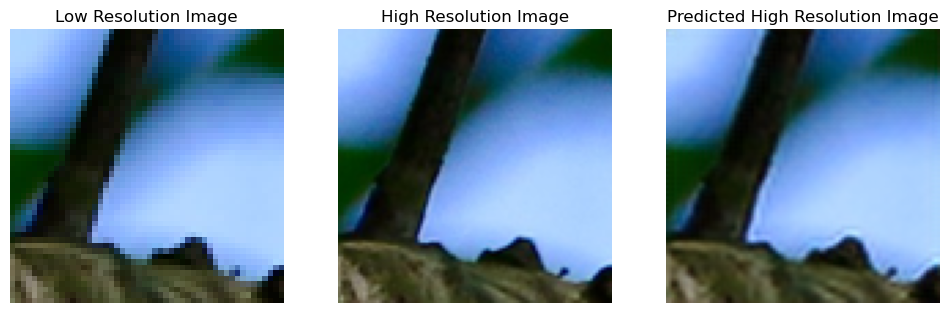

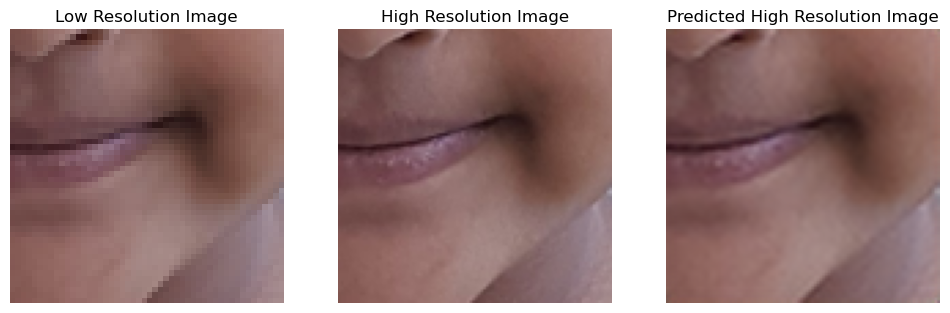

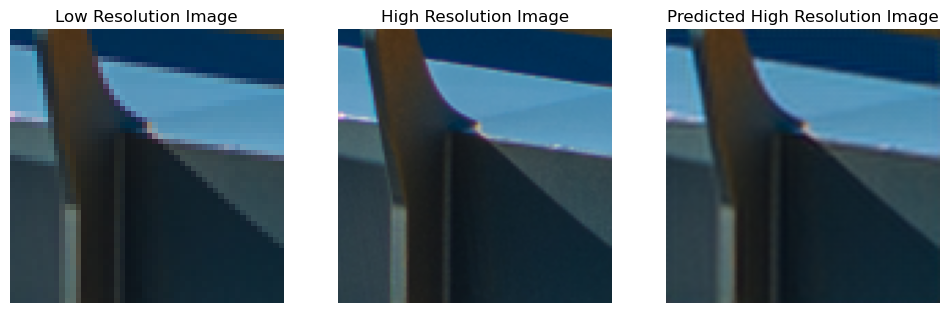

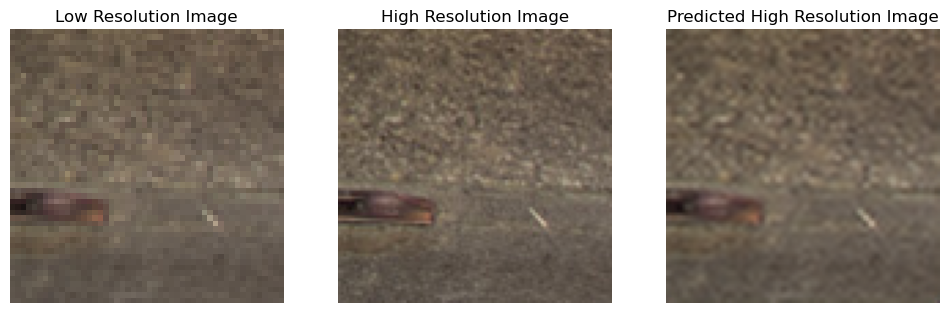

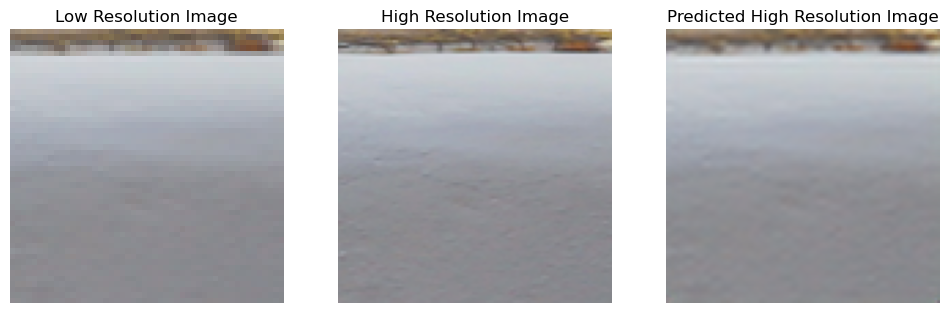

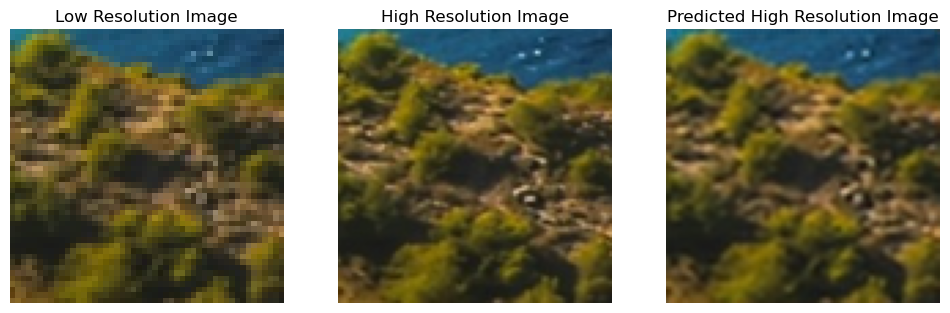

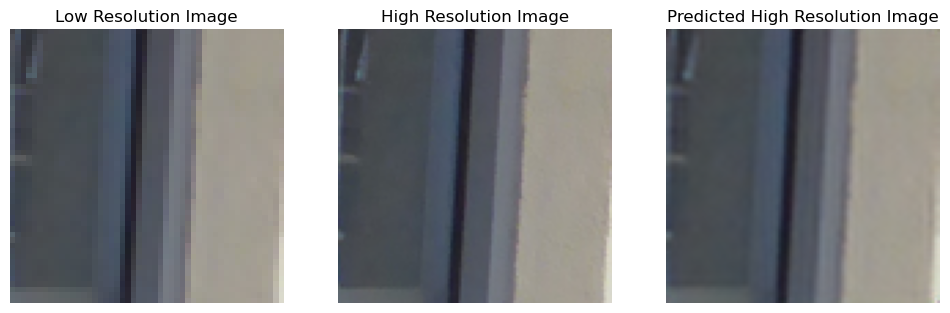

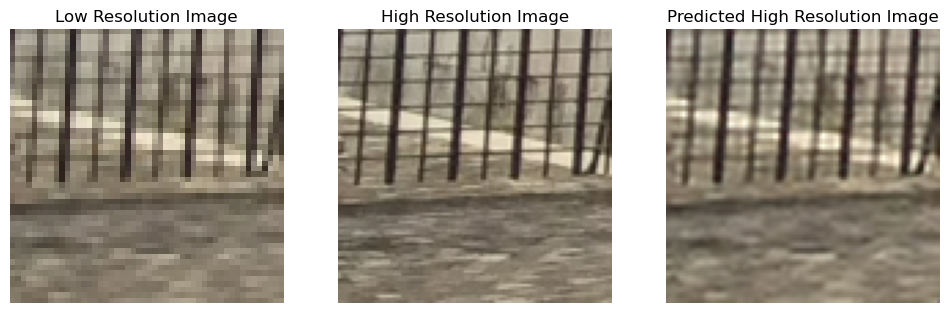

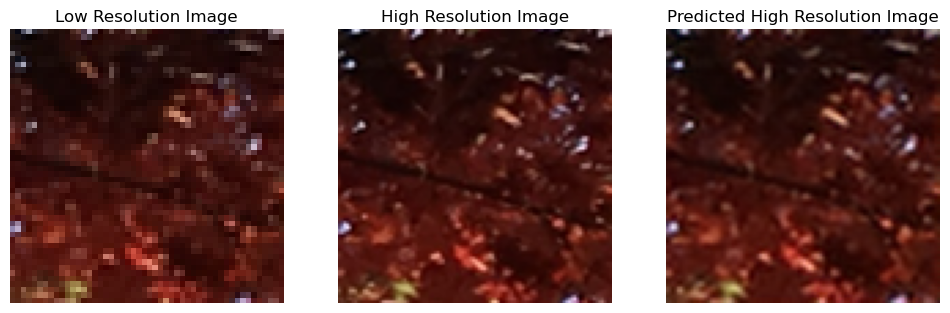

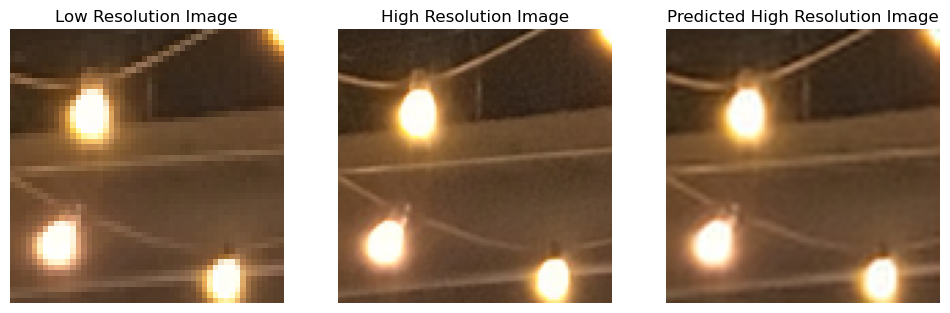

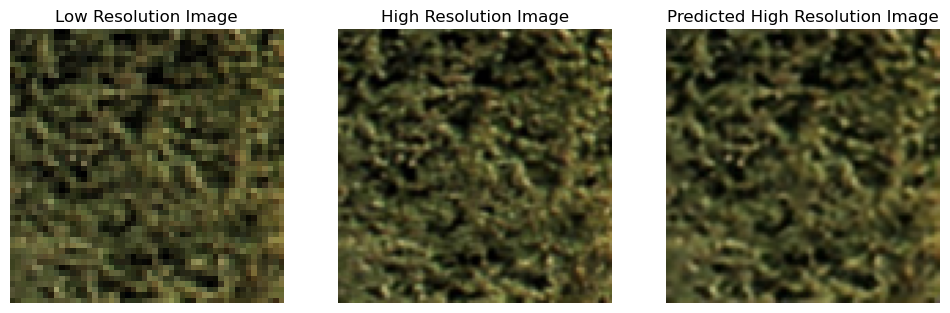

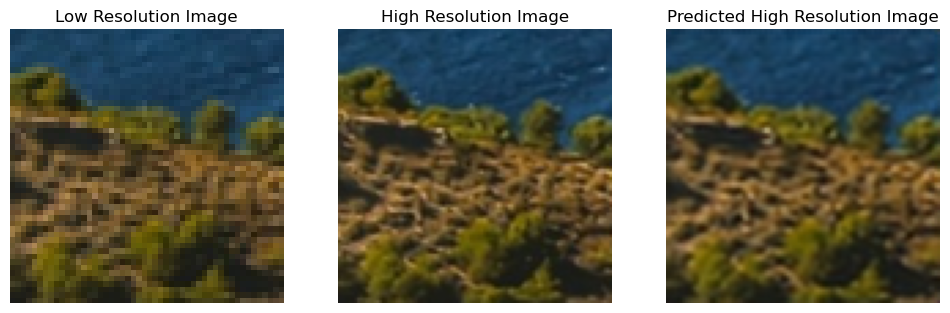

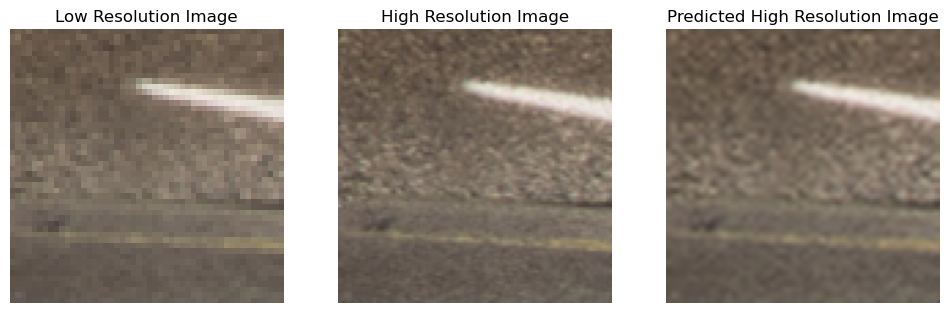

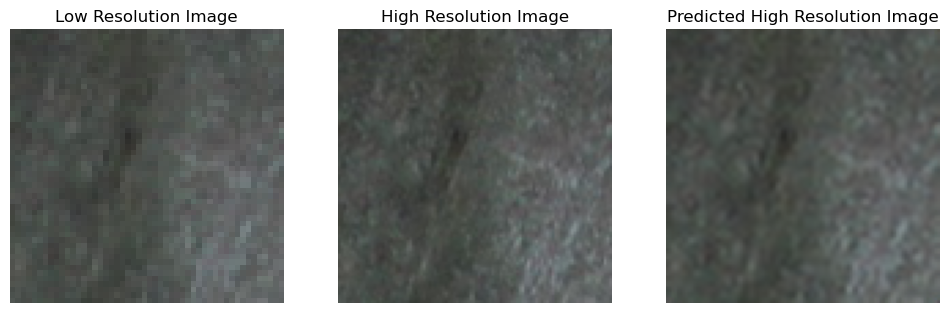

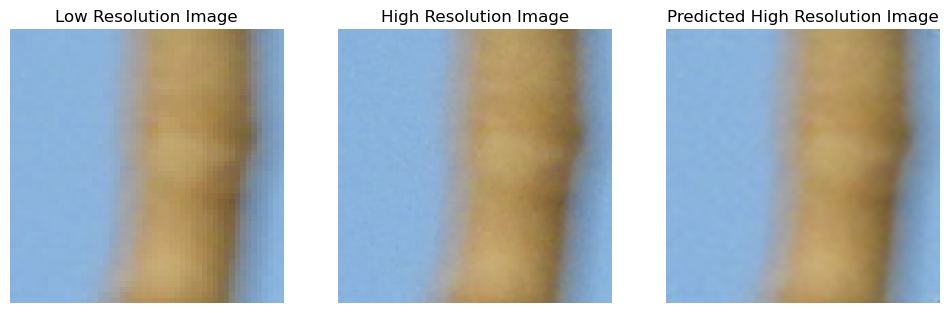

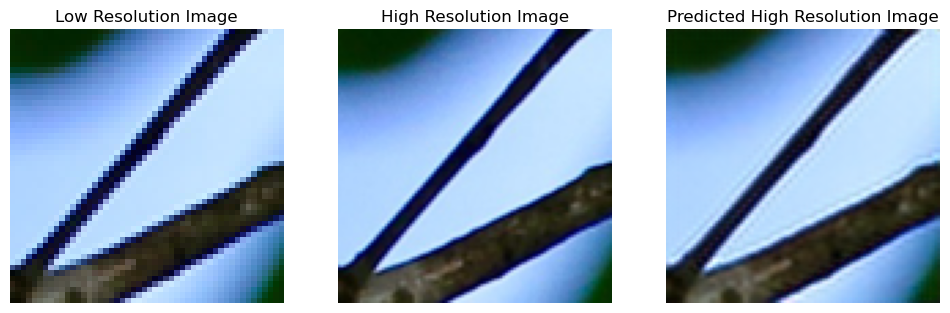

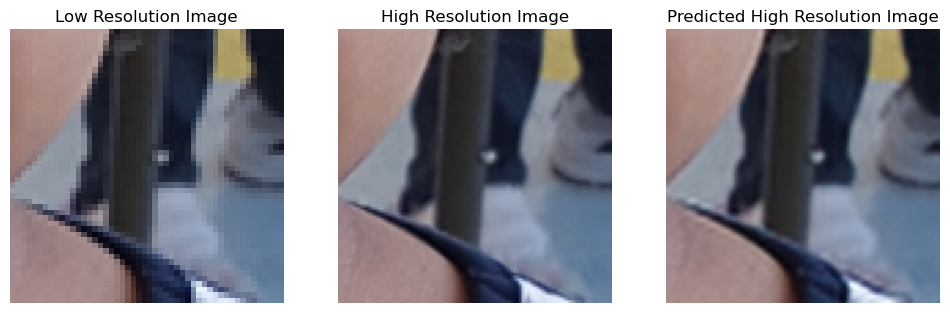

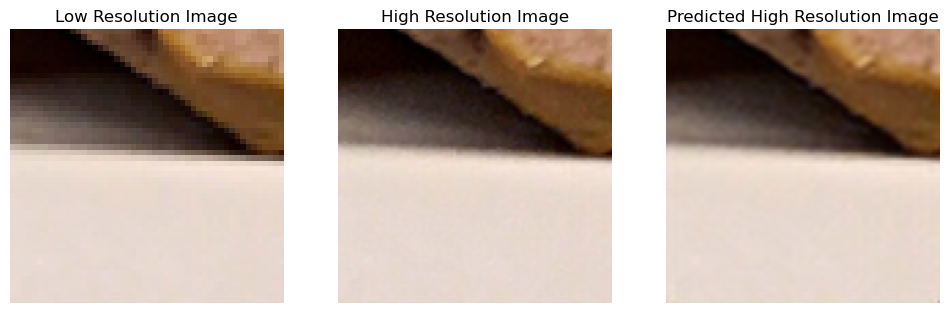

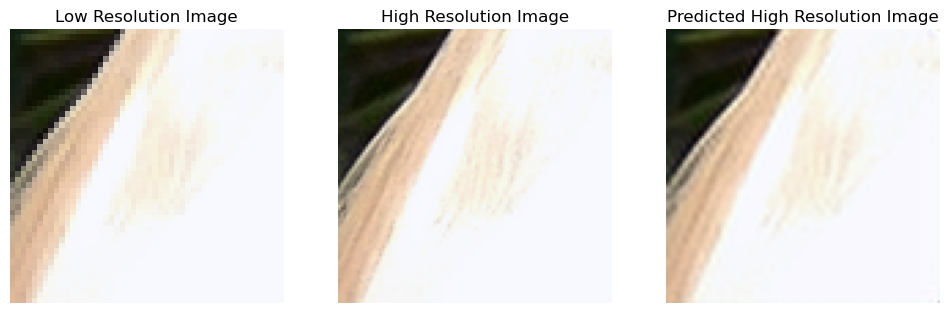

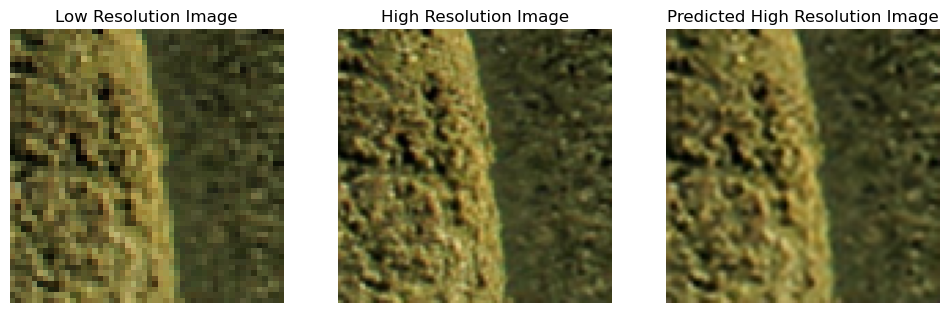

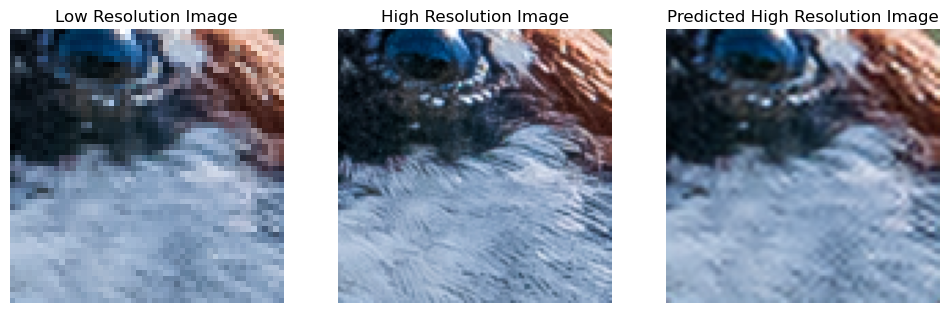

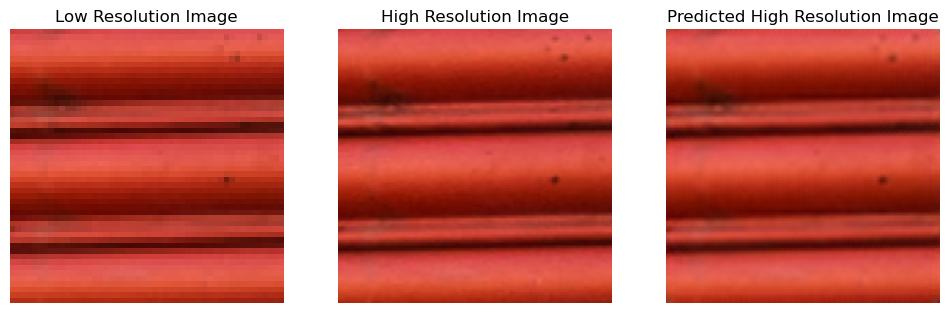

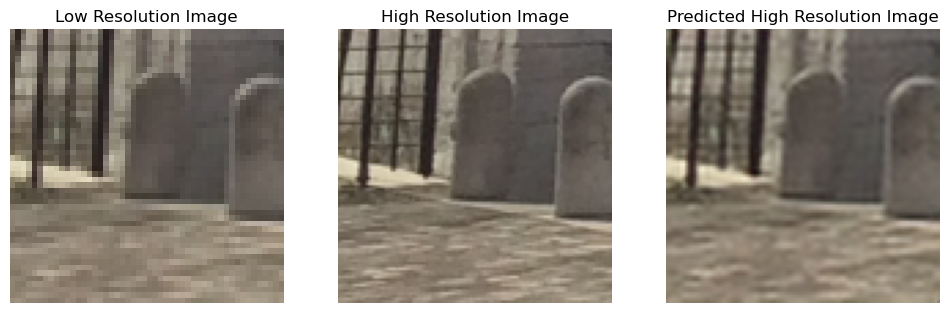

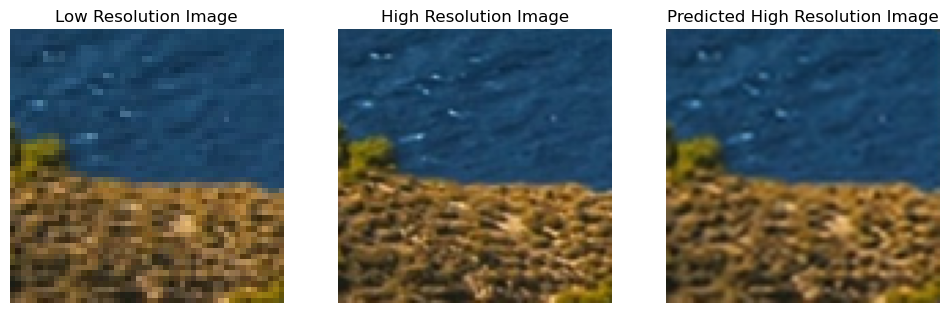

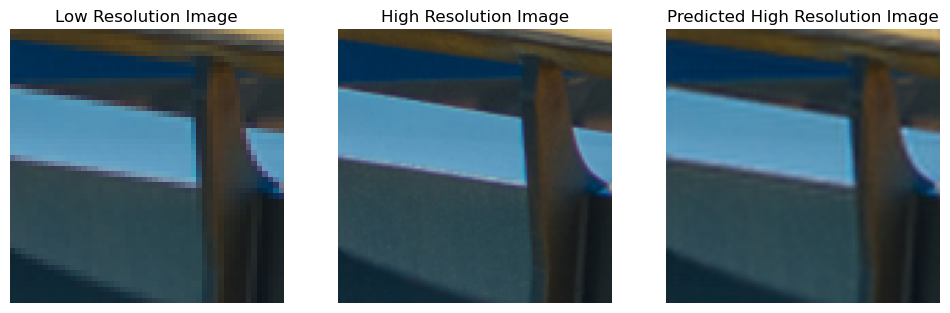

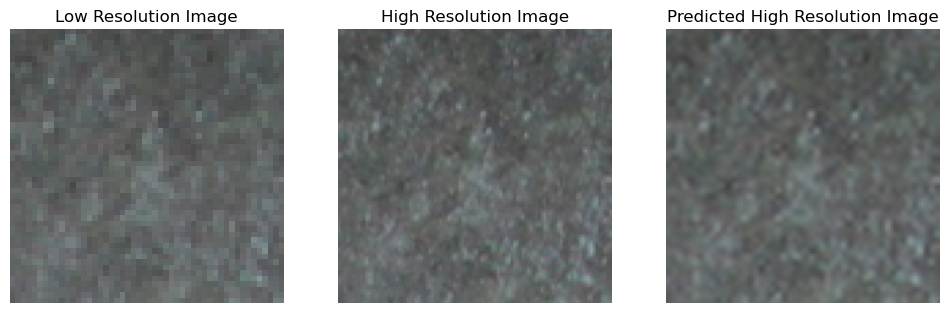

In [6]:
for i in range(BATCH_SIZE):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Low Resolution Image')
    plt.imshow(x_samples[i])
    plt.axis('off')


    plt.subplot(1, 3, 2)
    plt.title('High Resolution Image')
    plt.imshow(y_samples[i])
    plt.axis('off')


    plt.subplot(1, 3, 3)
    plt.title('Predicted High Resolution Image')
    plt.imshow(y_pred[i])
    plt.axis('off')

In [7]:
# save model to disk
model.save('unet_upscaling')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=unet_upscaling.